<img src="https://raw.githubusercontent.com/GeoscienceAustralia/dea-notebooks/stable/Supplementary_data/dea_logo_wide.jpg" 
     alt="DEA Notebooks logo" 
     style="width:80%;">

# ***Living Earth*** Exploring DEA Land Cover

🔎 Visit [DEA's Knowledge Hub](https://knowledge.dea.ga.gov.au/) for detailed technical information about the datasets and concepts used in this notebook.

<div style="
    border-left: 6px solid var(--jp-success-color1, #4CAF50);
    background-color: rgba(76, 175, 80, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>🚀 How you can run this notebook</b><br><br>
- <b>DEA Sandbox:</b> Eligible users can sign up for the 
<a href="https://sandbox.dea.ga.gov.au/" target="_blank">DEA Sandbox</a> 
that provides free compute and a managed Python environment.<br><br>
- <b>Personal computer:</b> This notebook loads DEA data using <code>odc-stac</code>. 
Data streams via the internet, so can be run locally after installing the required 
<a href="https://pypi.org/project/dea-tools/" target="_blank">DEA Tools</a> Python package, 
e.g. <code>pip install dea-tools[notebooks]</code>.
</div>

<div style="
    border-left: 6px solid var(--jp-info-color1, #2196F3);
    background-color: rgba(33, 150, 243, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>📦 Products used:</b><br>
<a href="https://explorer.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_3" target="_blank">ga_ls_landcover_class_cyear_3</a>
</div>


## Loading up an area based on a box

Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, and as part of *Living Earth*, land cover maps have been generated from 1988 to 2024 and for each year from Environmental Descriptors retrieved or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2; https://www.fao.org/4/y7220e/y7220e00.htm).  The spatial resolution of the mapping is 30 m
(see DEA Land Cover at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat).

This notebook allows you to explore the land cover maps for anywhere in Australia and for any period of time (noting the maps are generated annually from summary EDs).

You can define an area (based on coordinates of a box) and then you can load up and analyse the land cover and other EDs (e.g., lifeform, water persistence) used in their construction.  

To assist in the selection of your coordinates, you can click on the image (to be displayed in this notebook) and copy coordinates from the display.  Another option is to go to http://geojson.io and identify coordinates from there.  However, to get started, several areas have been pre-selected.

## Description 

This notebook will demonstrate how to load up an area of the Digital Earth Australia (DEA) land cover map and environmental descriptors used in their construction and description.   

The notebooks take you through the process of:

1. Setting up a time period for analysis.
2. Identifying an area based on a pre-defined coordinates for a rectangle.  
3. Displaying the Level 3 and level 4 land cover maps 
4. Displaying the EDs used to construct the land cover maps for Australia. 

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/DEA_products/DEA_Land_Cover.ipynb) first. 

***

### Load packages
The cell below imports Python packages that are used for the analysis.
The first command is `%matplotlib inline`, which ensures figures plot correctly in the Jupyter notebook.
The following commands import various functionality: 

* `sys` provides access to helpful support functions in the `dea_plotting` module. 
* `datacube` provides the ability to query and load data.
* `matplotlib` provides the ability to format and manipulate plots.

Note that other libraries are listed but will be used in later iterations of this notebook.  

In [1]:
# Initial imports and setup
import sys                                   # allows interaction with python (sys and support functions)
import os, re                                # allows interaction with the operating system (os) and regular expression library (re)

import matplotlib.pyplot as plt
from matplotlib import colors as mcolours

import numpy as np                           # NumPy handles raw numerical (including multi-dimensional) arrays
import xarray as xr                          # Xarray builds on NumPY but adds labels and metadata (e.g., dimensions, coordinates). 
import odc.stac                              # Part of the Open Data Cube (ODC) ecosystem; this library is designed to work with SpatioTemporal Asset Catalogs (STAC) APIs and datasets
import pystac_client                         # Searches and queries STAC catalogs
from odc.geo import BoundingBox              # BoundingBox is a simple class for defining spatial extents
from odc.geo.cog import write_cog            # Write_cog allows you to write Cloud Optimised GeoTIFFs (COGs)
from odc.geo.xr import assign_crs            # Assign a Coordinate Reference System (CRS) to an xarray DataArray or Dataset

from dea_tools.plotting import display_map   # Display interactive maps
from dea_tools.landcover import lc_colourmap, make_colourbar, plot_land_cover  # Provides plotting functions specific to DEA Land Cover

## Connect to DEA's STAC API
This allows us to search for data using DEA's STAC API (refer to the SpatioTemporal Asset Catalogue guide for details).

To load data, we must also configure access to DEA's Amazon S3 buckets using `odc.stac.configure_s3_access`. If launching a Dask client with `dea_tools.dask.create_local_dask_cluster()`, this is done automatically.

In [2]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)       # Configure access to public data on AWS S3 without requiring credentials

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac") # Connect to Digital Earth Australia's (DEA) STAC API

## Select the parameters for the analysis

Set the product, time range, spatial boundary, spatial resolution and projection (CRS) for the data you want to load.

ga_ls_landcover_class_cyear_3 is Geoscience Australia's (GA) Landsat-derived land cover classification.

Note that the CRS is the Australian Albers Equal Area projection (EPSG: 3577), where EPSG is the European Petroleum Survey Group.

In [3]:
product='ga_ls_landcover_class_cyear_3'

# Set the range of dates for the analysis. Note that the land cover maps are annual from 1988 to 2024

time_range = ("2020", "2024")

# Coordinates for Broome, Western Australia
# central_lat = -18.10
# central_lon = 122.32

# Sydney, New South Wales, Australia
central_lat = -33.9
central_lon = 151.24

buffer = 0.5       # This buffer can be changed and is in degrees
resolution=30      # The spatial resolution of the maps (i.e., 30 m)
crs='EPSG:3577'

## Query the STAC catalog for items relating to your query
Note that based on the information above, you are setting up a bounding box that can be queried. This can be for anywhere in Australia but you will need to adjust the central latitude and longitude and the buffer.  Once you have defined the box query, you can then search the catalogue of data (see: https://explorer.dea.ga.gov.au/stac)

In [4]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching land cover  data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time_range
    )

items = list(query.items()) #convert to list
print(f"Found: {len(items):d} datasets")

Found: 20 datasets


After choosing the study area, it can be useful to visualise it on an interactive map.
This provides a sense of scale.
> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

In [5]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)
display_map(x=study_area_lon, y=study_area_lat)

### Load DEA land cover
This section reads the data from the data cube, with this including the land cover and environmental descriptor measurements (ga_ls_landcover_class_cyear_2) and the output Coordinate Reference System (CRS; see https://epsg.io/?q= and also https://datacarpentry.org/organization-geospatial/03-crs.html))

In [6]:
#now load the data with odc-stac
lc = odc.stac.load(
    items, #stac items
    bands=["level3", "level4"], #theses are the only two measurements
    crs=crs,
    resolution=resolution,
    bbox=bbox, #area to load over
)

Following the load step, printing the `lc` `xarray.Dataset` object will give you insight into all of the data that was loaded.
Do this by running the next cell.

The data are represented by the following aspects:
- `Dimensions`: the names of data dimensions, frequently `time`, `x` and `y`, and number of entries in each
- `Coordinates`: the coordinate values for each point in the data cube, including time.
- `Data variables`: the observations loaded, with this including the environmental descriptors and full land cover classification.
- `Attributes`: additional useful information about the data, such as the `crs` (coordinate reference system)

In [7]:
lc

<xarray.Dataset> Size: 594MB
Dimensions:      (y: 4136, x: 3590, time: 5)
Coordinates:
  * y            (y) float64 33kB -3.771e+06 -3.771e+06 ... -3.895e+06
  * x            (x) float64 29kB 1.71e+06 1.71e+06 ... 1.817e+06 1.817e+06
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 40B 2020-01-01 2021-01-01 ... 2024-01-01
Data variables:
    level3       (time, y, x) float32 297MB 112.0 112.0 112.0 ... 220.0 220.0
    level4       (time, y, x) float32 297MB 27.0 27.0 27.0 ... 101.0 101.0 101.0

## Plot Level 3 descriptors

The Level 3 classification contains six base classes:

111: Cultivated Terrestrial Vegetation: Vegetation that has been changed by human influence, such as planted crops or improved pasture. This is different from areas left to minor grazing or fallow.

112: Natural Terrestrial Vegetation: Vegetation that has not been changed by human influence. This includes native forests as well as pastures or paddocks left unchanged for the year. It does not identify whether the vegetation is native or otherwise.

124: Natural Aquatic Vegetation: Vegetation that gets regularly inundated with water. Natural Aquatic Vegetation is generally associated with swamps, fens, flooded forests, saltmarshes, or mangroves. Only mangroves are included in the current release.

215: Artificial Surface: Human-made, unvegetated areas. This includes the roofs of houses, concrete areas, road surfaces and other similar surfaces that we associate with civilisation.

216: Natural Bare Surface: Mostly bare soil. It is very likely that there is still vegetation in the area, but it is dominated by soil.

220: Water Terrestrial and coastal open water such as dams, lakes, large rivers and the coastal and near-shore zone.

To plot the level3 data, we will use the plot_layer() function. The plot_layer() function allows you to define your own colour map as shown in the cell below. The keys respond to the Level 3 classifications, and the values are colour specifications (red, green, blue, alpha) and labels to be used in the legend.

In [8]:
# Define a colour scheme for the Level 3
LEVEL3_COLOUR_SCHEME = {
    111: (172, 188, 45, 255, "Cultivated terrestrial vegetation"),
    112: (14, 121, 18, 255, "Natural terrestrial vegetation"),
    124: (30, 191, 121, 255, "Natural aquatic vegetation"),
    215: (218, 92, 105, 255, "Artificial surface"),
    216: (243, 171, 105, 255, "Natural bare surface"),
    220: (77, 159, 220, 255, "Water"),
    255: (255, 255, 255, 255, "No Data"),
}

The following cell defines the plot_layer() function which takes DEA Land Cover data and a colour map as arguments.

In [9]:
def plot_layer(colours, data, col_wrap, size=5):
    colour_arr = []
    for key, value in colours.items():
        colour_arr.append(np.array(value[:-1]) / 255)
 
    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours)
    bounds.append(256) # add upper bound to make sure highest value (255) included in last colour bin
    norm = mcolours.BoundaryNorm(np.array(bounds) - 0.1, cmap.N)
    labels = {'ticks' : [111,112,124,215,216,220,255],}

    if len(data.time) == 1: 
        # Plot the provided layer
        im = data.isel(time=0).plot(
        cmap=cmap, norm=norm, add_colorbar=True, size=size, cbar_kwargs=labels
        )

    else:
        # Plot the provided layer
        im = data.plot(
        cmap=cmap, norm=norm, add_colorbar=True, col="time", col_wrap=col_wrap, size=size, cbar_kwargs=labels
        )
 
    return im

The following plots are then generated for each year.

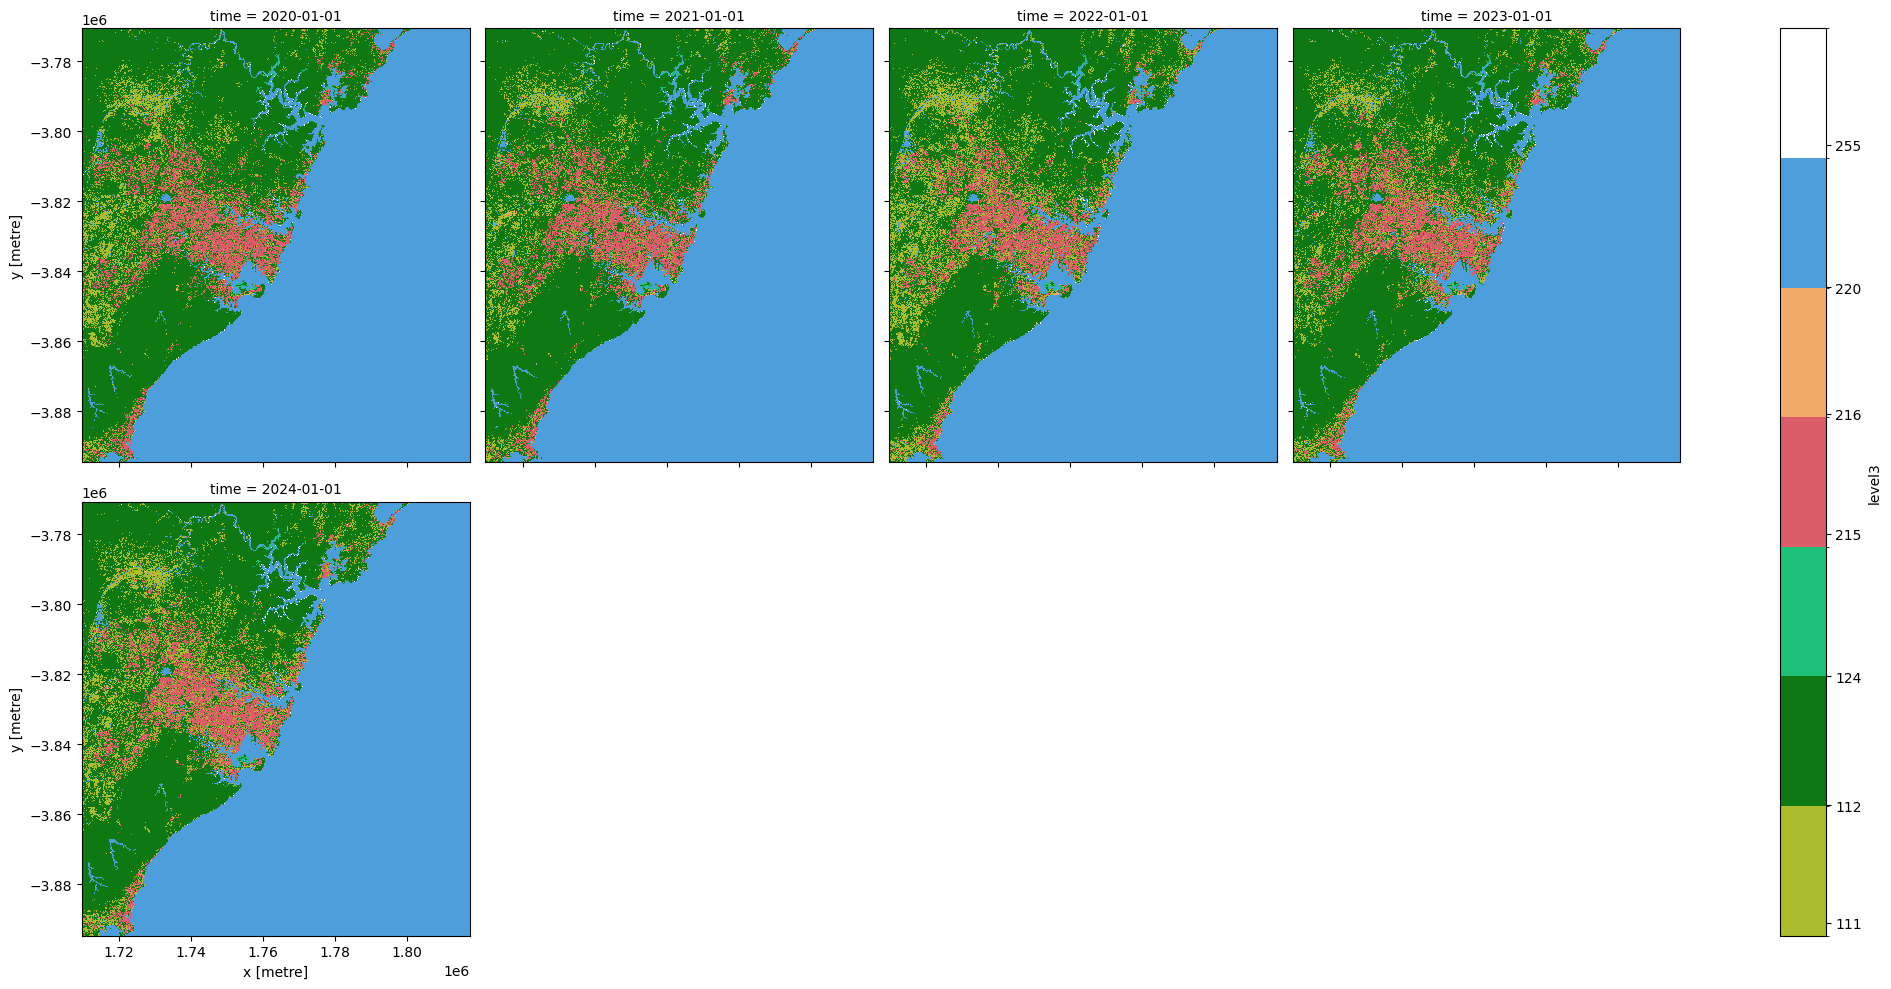

In [10]:
plot_layer(LEVEL3_COLOUR_SCHEME, lc.level3, col_wrap=4);

In [12]:
lc.level3[1]
unique_vals = np.unique(lc.level3.values)

print(unique_vals)

[111. 112. 124. 215. 216. 220.  nan]


## Plot Level 4: Environmental descriptors

We can use the pre-canned function, `dea-tools.landcover.plot_land_cover`

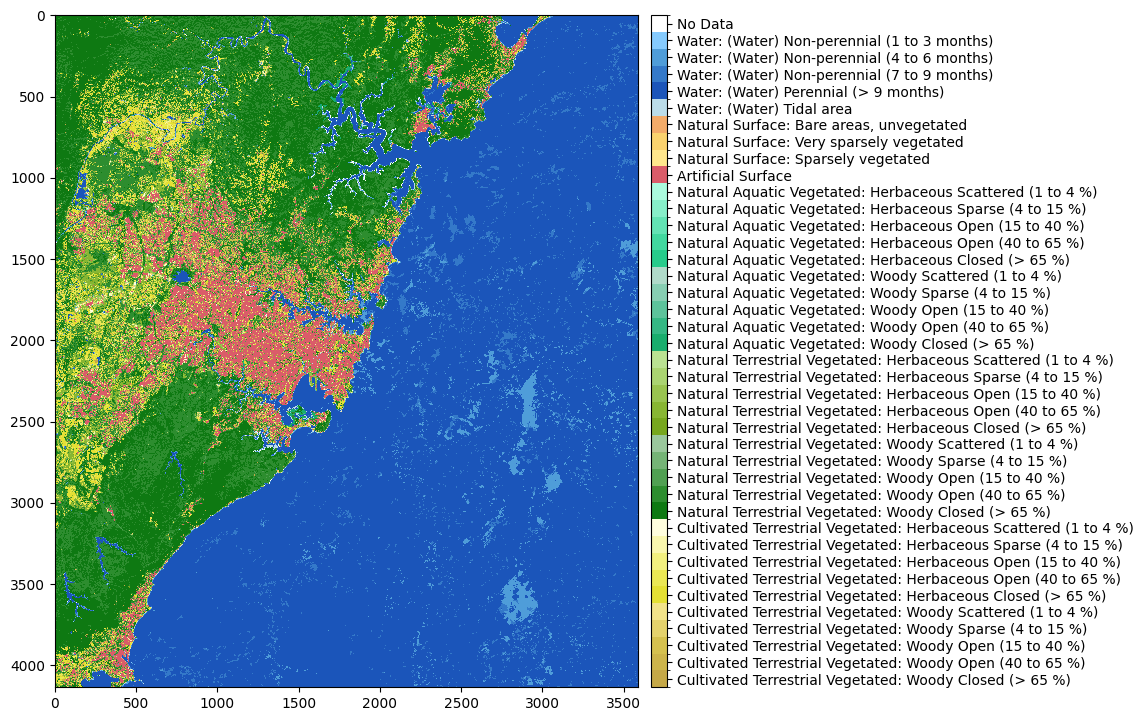

In [13]:
plot_land_cover(lc.level4, year='2024', width_pixels=600);

In [14]:
lc.level4[3]
unique_vals = np.unique(lc.level4.values)

print(unique_vals)

[  2.   3.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  20.  21.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  56.  57.  64.  65.
  67.  68.  70.  71.  73.  74.  79.  82.  85.  88.  91.  93.  94.  95.
  96.  97.  99. 100. 101. 102. 103. 104.  nan]


## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2025